#

scVI is a deep generative model that has been developed for probabilistic representation of scRNA-seq data and performs well in both harmonization and harmonization-based annotation, going beyond just correcting batch effects. SCANVI is a new method that is designed to harmonize datasets, while also explicitly leveraging any available labels to achieve more accurate annotation. SCANVI uses a semi-supervised generative model. The inference of both models (scVI, SCANVI) is done using neural networks, stochastic optimization, and variational inference and scales to millions of cells and multiple datasets. Furthermore, both methods provide a complete probabilistic representation of the data, which non-linearly controls not only for sample-to-sample bias, but also for other technical factors of variation such as over-dispersion, variable library size, and zero-inflation.

*scVI* is a hierarchical Bayesian model for single-cell RNA sequencing data with conditional distributions parametrized by neural networks. Working as a hybrid between a neural network and a bayesian network, scVI performs data harmonization. VAE refers to variational auto-encoders for single-cell gene expression data. scVI is similar to VAE as it tries to bring a more suitable structure to the latent space. While VAE allows users to make observations in a semi-supervised fashion, scVI is easier to train and specific cell-type labels for the dataset are not required in the pure unsupervised case.

scVI:
```{bash}
counts x
    ↓
 Encoder NN
    ↓
 latent z
    ↓
 Decoder NN
    ↓
 NB parameters → reconstruct counts
```

scANVI = scVI + a neural classifier head and a label generative decoder, enabling semi-supervised learning where both gene expression and cell-type labels are modeled from the same latent space. scANVI:
```{bash}
counts x                      (optional labels y, where available)
    ↓                                   │
 Encoder NN                             │  
    ↓                                   │
 latent z -------------------------------┘
    │
    ├──→ Gene Decoder NN → NB params → reconstruct x
    │
    └──→ Label Decoder NN → categorical probs → predict y

```


1. Train scANVI on biopsies (GSE179640)

Use cell-type labels from the paper or your own annotation
Learn a reference atlas with a built-in classifier

2. Freeze model + use scArches to map menstrual effluent (GSE203191)

Loads new cells into the biopsy atlas
Classifier head stays frozen
Predicts cell types and disease-state signatures in a consistent framework

3. For endometriosis classification

You can add an additional classifier trained on biopsy latent space
Or include disease labels in scANVI as cell-type subclasses (advanced option)

In [14]:
from pathlib import Path
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import os
import tempfile

import anndata as ad
import scanpy as sc
import scvi
import torch

import joblib
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
#!pip install xgboost
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score



In [2]:
scvi.settings.seed = 1234
print("Last run with scvi-tools version:", scvi.__version__)

sc.set_figure_params(figsize=(6, 6), frameon=False)
sns.set_theme()
torch.set_float32_matmul_precision("high")
save_dir = tempfile.TemporaryDirectory()

Seed set to 1234


Last run with scvi-tools version: 1.4.0.post1


In [3]:
os.chdir("/home/katwre/projects/Endometriosis/")

In [4]:
adata_ref = sc.read_h5ad("data/processed/02_control_disease_stromal_cells_GSE179640_RAW.h5ad")
adata_blood = sc.read_h5ad("data/processed/01_processed_qc_clustering_GSE203191_RAW.h5ad")

In [ ]:
# Train scVI on biopsies (GSE179640)

#scvi.model.SCVI.setup_anndata(adata_ref, batch_key="sample_id")

#model_ref = scvi.model.SCVI(adata_ref, n_latent=20)
#model_ref.train()

#model_ref.save(
#    "/content/drive/MyDrive/Endometriosis/data/processed/scvi_ref_model",
#    overwrite=True,
#)

In [5]:
model_ref = scvi.model.SCVI.load(
    "data/processed/scvi_ref_model",
    adata_ref,   # use the SAME AnnData you trained on
)

INFO     File data/processed/scvi_ref_model/model.pt already downloaded                                            


/home/katwre/.local/share/virtualenvs/Endometriosis-pNZatqoH/lib/python3.12/site-packages/scvi/data/fields/_base_field.py:63: UserWarning: adata.X does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)


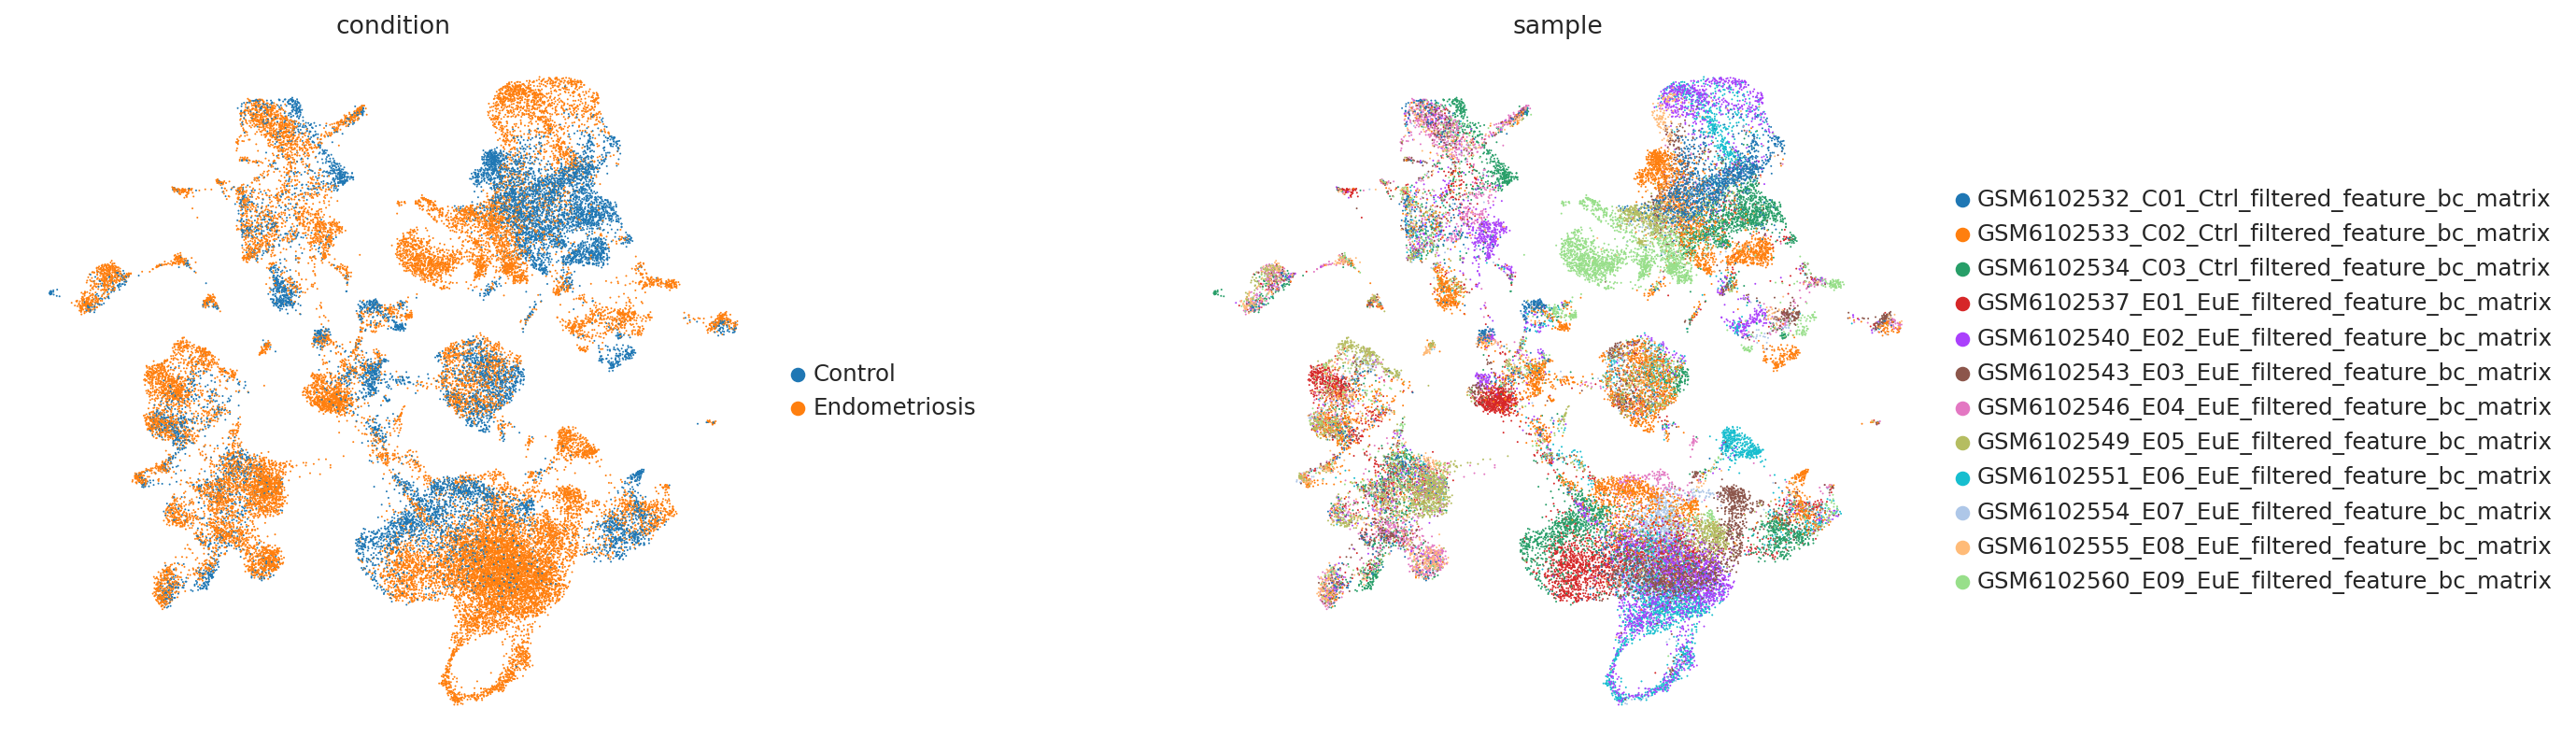

In [6]:
z_ref  = model_ref.get_latent_representation()

adata_ref.obsm["X_scVI"] = z_ref

sc.pp.neighbors(adata_ref, use_rep="X_scVI")
sc.tl.umap(adata_ref)

sc.pl.umap(
    adata_ref,
    color=["condition", "sample"],
    wspace=0.4,
)

In [ ]:
# Train a simple classifier (external model)
# This classifier learns: Which regions of latent space = endometriosis.

#z_ref = model_ref.get_latent_representation()
#y_ref = adata_ref.obs["condition"]  # endo/control

#clf = LogisticRegression(max_iter=2000) # I forgot here the argument class_weight="balanced" to account for class imbalance that quite a bit in the data!!
#clf.fit(z_ref, y_ref)

#joblib.dump(clf, "data/processed/simple_endo_classifier.joblib")

In [ ]:
# Save the reference model (only three endometriosis samples I could confirm)
#adata = adata_blood  
#targets = ["MEtissue4", "MEtissue6", "MEtissue7"]
#mask = adata.obs["sample"].astype(str).str.contains("|".join(targets))
#adata_filt = adata[mask].copy()
#adata_filt.write_h5ad(
#    "data/processed/01_processed_qc_clustering_GSE203191_MEtissue_4_6_7.h5ad"
#)

In [7]:
# Map GSE203191 (menstrual effluent) using scArches

adata_query = sc.read_h5ad("data/processed/01_processed_qc_clustering_GSE203191_MEtissue_4_6_7.h5ad")
# assuming you still have adata_ref in memory
common_genes = adata_ref.var_names.intersection(adata_query.var_names)
adata_ref = adata_ref[:, common_genes].copy()
adata_query = adata_query[:, common_genes].copy()


#model_query = scvi.model.SCVI.load_query_data(
#    adata_query,
#    "data/processed/scvi_ref_model",
#    freeze_expression=True,
#    freeze_decoder_first_layer=True,
#    freeze_batchnorm_encoder=True,
#    freeze_batchnorm_decoder=False,
#)
#model_query.train(max_epochs=40)

#model_query.save(
#    "data/processed/scvi_query_model",
#    overwrite=True,
#)

In [8]:
model_query = scvi.model.SCVI.load(
    "data/processed/scvi_query_model",
    adata_query,   # use the SAME AnnData you trained on
)

INFO     File data/processed/scvi_query_model/model.pt already downloaded                                          


/home/katwre/.local/share/virtualenvs/Endometriosis-pNZatqoH/lib/python3.12/site-packages/scvi/data/fields/_base_field.py:63: UserWarning: adata.X does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)


In [9]:
# Predict endometriosis on menstrual effluent
# This is all scVI + a simple classifier.

z_query = model_query.get_latent_representation()
clf = joblib.load("data/processed/simple_endo_classifier.joblib")
p_endo = clf.predict_proba(z_query)[:,1]

# Aggregate by sample:
df = pd.DataFrame({
    "sample": adata_query.obs["sample_id"],
    "p_endo": p_endo
})
sample_scores = df.groupby("sample")["p_endo"].mean()

/home/katwre/.local/share/virtualenvs/Endometriosis-pNZatqoH/lib/python3.12/site-packages/sklearn/base.py:442: InconsistentVersionWarning: Trying to unpickle estimator LogisticRegression from version 1.6.1 when using version 1.7.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/tmp/ipykernel_229358/3914282274.py:13: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  sample_scores = df.groupby("sample")["p_endo"].mean()


In [10]:
print(sample_scores)

sample
GSM6161377_MEtissue4_filtered_feature_bc_matrix    0.629474
GSM6161379_MEtissue6_filtered_feature_bc_matrix    0.565412
GSM6161380_MEtissue7_filtered_feature_bc_matrix    0.579462
Name: p_endo, dtype: float64


In [11]:
z_ref  = model_ref.get_latent_representation()
z_query = model_query.get_latent_representation()

adata_combined = ad.concat(
    [adata_ref, adata_query],
    join="outer",
    label="dataset",
    keys=["biopsy", "ME"],
    index_unique="-",
)

adata_combined.obsm["X_scVI"] = np.vstack([z_ref, z_query])

sc.pp.neighbors(adata_combined, use_rep="X_scVI")
sc.tl.umap(adata_combined)


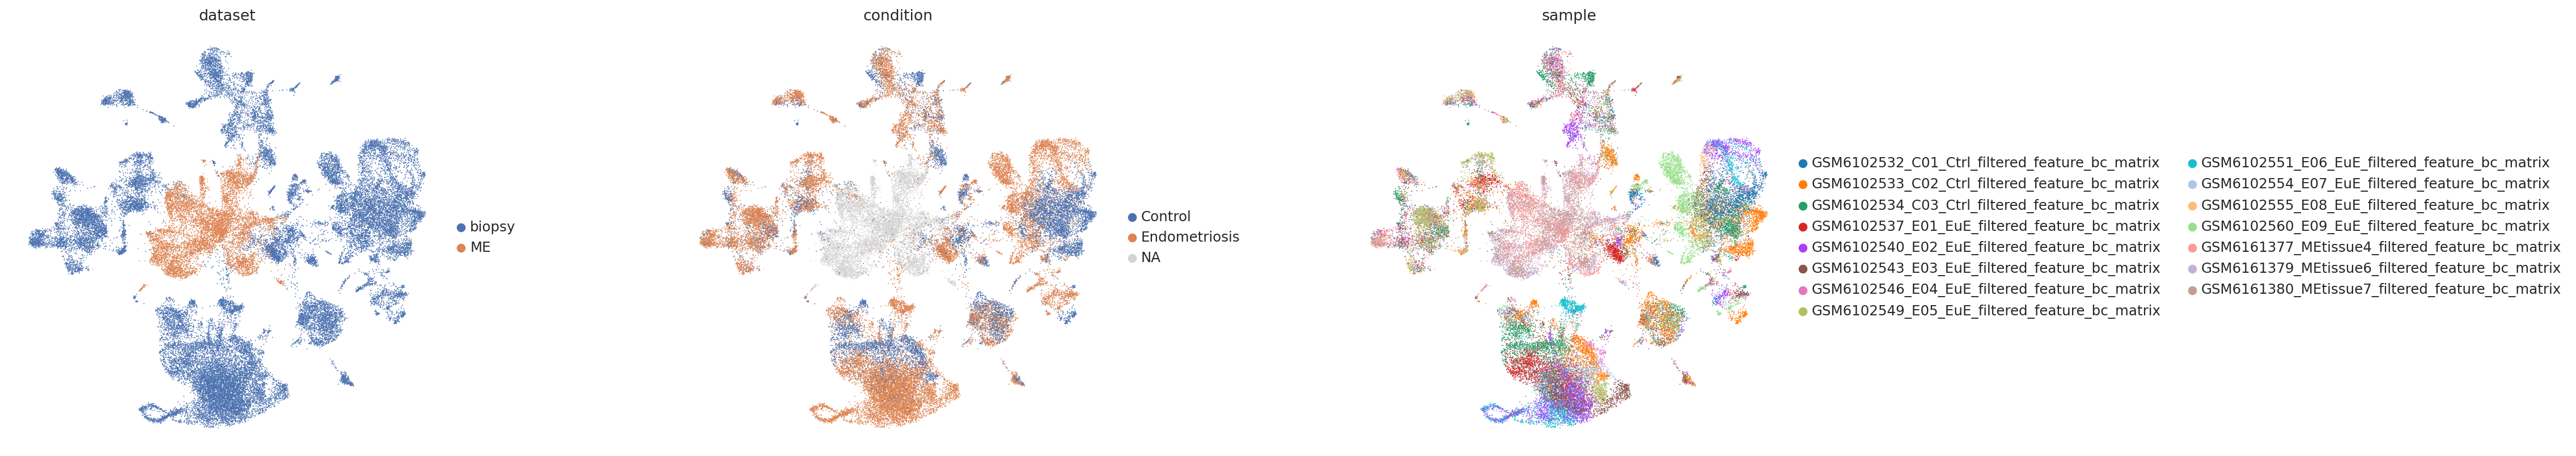

In [12]:
sc.pl.umap(
    adata_combined,
    color=["dataset", "condition", "sample"],
    wspace=0.4,
)


**Menstrual effluent (ME) cells do not overlap tightly with either endometriosis or control biopsy cells.** Instead, ME cells sit between the biopsy clusters, partially overlapping with both groups but also forming their own separate islands. It reflects both biological and technical differences between sample types.

Biological differences:
- **ME contains leukocytes, platelets, immune cells, and stromal fragments.**
- **Biopsy datasets** are enriched for stromal, epithelial, fibroblast, and endothelial populations.
- **ME has peripheral blood contamination**, which shifts its transcriptional profile.
- The **disease signal in ME is weaker** and often restricted to specific cell types.

Because menstrual effluent is not the same tissue type as an endometrial biopsy, ME cells will not neatly fall inside biopsy-defined disease clusters.

This UMAP is showing most likely biologically realistic domain shift.


### Compare different classificators on top of the latent space

In [ ]:
# ---------------------------------------------------
# 1. Get latent space + labels (ALL biopsy cells)
# ---------------------------------------------------

z_ref = model_ref.get_latent_representation()
y_ref = adata_ref.obs["condition"].astype(str)   # "Endometriosis" / "Control"

print("Latent shape (all biopsy cells):", z_ref.shape)
print("Class counts:\n", y_ref.value_counts())

POS_LABEL = "Endometriosis"   # positive class name

# ---------------------------------------------------
# 2. Logistic Regression (baseline)
# ---------------------------------------------------
log_reg = LogisticRegression(
    max_iter=2000,
    class_weight="balanced"   # important with imbalance
)
log_reg.fit(z_ref, y_ref)
joblib.dump(log_reg, "data/processed/clf_all_logreg.joblib")

# Optional: check training AUC
y_bin = (y_ref == POS_LABEL).astype(int)
p_log = log_reg.predict_proba(z_ref)[:, list(log_reg.classes_).index(POS_LABEL)]
print("Train AUC – Logistic:", roc_auc_score(y_bin, p_log))

# ---------------------------------------------------
# 3. MLP classifier (small fully-connected NN)
# ---------------------------------------------------
mlp = make_pipeline(
    StandardScaler(),
    MLPClassifier(
        hidden_layer_sizes=(128, 64),
        activation="relu",
        max_iter=200,
        alpha=1e-4,
        learning_rate_init=1e-3,
        random_state=0,
    )
)
mlp.fit(z_ref, y_ref)
joblib.dump(mlp, "data/processed/clf_all_mlp.joblib")

p_mlp = mlp.predict_proba(z_ref)[:, 1]  # pipeline has only 2 classes, pos is index 1
print("Train AUC – MLP:", roc_auc_score(y_bin, p_mlp))

# ---------------------------------------------------
# 4. XGBoost classifier
# ---------------------------------------------------
# XGBoost expects numeric labels; use 0/1
scale_pos_weight = (y_bin == 0).sum() / (y_bin == 1).sum()
print(f"scale_pos_weight for XGB: {scale_pos_weight:.2f}")

xgb = XGBClassifier(
    n_estimators=400,
    max_depth=4,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    objective="binary:logistic",
    eval_metric="logloss",
    scale_pos_weight=scale_pos_weight,
    n_jobs=-1,
    random_state=0,
)
xgb.fit(z_ref, y_bin)
joblib.dump(xgb, "data/processed/clf_all_xgb.joblib")

p_xgb = xgb.predict_proba(z_ref)[:, 1]
print("Train AUC – XGBoost:", roc_auc_score(y_bin, p_xgb))


Latent shape (all biopsy cells): (37503, 20)
Class counts:
 condition
Endometriosis    26183
Control          11320
Name: count, dtype: int64
Train AUC – Logistic: 0.7151520070274605


/home/katwre/.local/share/virtualenvs/Endometriosis-pNZatqoH/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Train AUC – MLP: 0.9993274386760541
scale_pos_weight for XGB: 0.43
Train AUC – XGBoost: 0.9463550716491388


In [16]:
POS_LABEL = "Endometriosis"   # make sure this matches adata_ref.obs["condition"]

# ---------------------------------------------------
# 1. Latent space for ME (all cells)
# ---------------------------------------------------
z_query = model_query.get_latent_representation()
print("ME latent shape:", z_query.shape)

# ---------------------------------------------------
# 2. Load trained classifiers (all cells, biopsy-trained)
# ---------------------------------------------------
log_reg = joblib.load("data/processed/clf_all_logreg.joblib")
mlp     = joblib.load("data/processed/clf_all_mlp.joblib")
xgb     = joblib.load("data/processed/clf_all_xgb.joblib")

# Helper: get index of the positive class
def pos_idx(clf, pos_label=POS_LABEL):
    return list(clf.classes_).index(pos_label)

# ---------------------------------------------------
# 3. Per-cell endo probabilities
# ---------------------------------------------------
# Logistic regression
idx_log = pos_idx(log_reg)
p_log = log_reg.predict_proba(z_query)[:, idx_log]

# MLP (pipeline exposes .classes_ as well)
idx_mlp = pos_idx(mlp)
p_mlp = mlp.predict_proba(z_query)[:, idx_mlp]

# XGBoost (trained on 0/1 → positive class is column 1)
p_xgb = xgb.predict_proba(z_query)[:, 1]

# Store on ME AnnData
adata_query.obs["p_endo_logreg"] = p_log
adata_query.obs["p_endo_mlp"]    = p_mlp
adata_query.obs["p_endo_xgb"]    = p_xgb

# ---------------------------------------------------
# 4. Aggregate by sample_id
# ---------------------------------------------------
df = adata_query.obs[["sample_id", "p_endo_logreg", "p_endo_mlp", "p_endo_xgb"]].copy()

sample_scores_logreg = df.groupby("sample_id")["p_endo_logreg"].mean()
sample_scores_mlp    = df.groupby("sample_id")["p_endo_mlp"].mean()
sample_scores_xgb    = df.groupby("sample_id")["p_endo_xgb"].mean()

print("\nSample-level p_endo (Logistic):")
print(sample_scores_logreg)

print("\nSample-level p_endo (MLP):")
print(sample_scores_mlp)

print("\nSample-level p_endo (XGBoost):")
print(sample_scores_xgb)


ME latent shape: (8141, 20)

Sample-level p_endo (Logistic):
sample_id
GSM6161377_MEtissue4_filtered_feature_bc_matrix    0.436246
GSM6161379_MEtissue6_filtered_feature_bc_matrix    0.369443
GSM6161380_MEtissue7_filtered_feature_bc_matrix    0.379594
Name: p_endo_logreg, dtype: float64

Sample-level p_endo (MLP):
sample_id
GSM6161377_MEtissue4_filtered_feature_bc_matrix    0.861117
GSM6161379_MEtissue6_filtered_feature_bc_matrix    0.797645
GSM6161380_MEtissue7_filtered_feature_bc_matrix    0.836060
Name: p_endo_mlp, dtype: float32

Sample-level p_endo (XGBoost):
sample_id
GSM6161377_MEtissue4_filtered_feature_bc_matrix    0.433091
GSM6161379_MEtissue6_filtered_feature_bc_matrix    0.402569
GSM6161380_MEtissue7_filtered_feature_bc_matrix    0.372267
Name: p_endo_xgb, dtype: float32


/tmp/ipykernel_229358/1561829077.py:44: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  sample_scores_logreg = df.groupby("sample_id")["p_endo_logreg"].mean()
/tmp/ipykernel_229358/1561829077.py:45: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  sample_scores_mlp    = df.groupby("sample_id")["p_endo_mlp"].mean()
/tmp/ipykernel_229358/1561829077.py:46: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  sample_scores_xgb    = df.g

Since classification of the menstrual effluent samples using all cells does not perform well with logistic regression or XGBoost (both giving sample-level scores < 0.5), and the MLP model most likely overfits, I will repeat the analysis focusing only on stromal cells.

In the differential expression analysis in `notebooks/02_control_disease_GSE179640.ipynb`, stromal cells showed a much clearer separation between endometriosis and control samples, which is also biologically consistent with what is known about the disease. Endometrial stromal cells undergo cyclical decidualization and are among the first cell types to become dysfunctional in endometriosis, so restricting the model to stromal cells may amplify the disease-specific signal.

By focusing only on stromal cells, I also remove immune cells, which are noisy, variable across the menstrual cycle, and often the most challenging to integrate across datasets. Although immune dysregulation is a key component of endometriosis, stromal cells tend to provide a cleaner and more stable transcriptional signature of the disease, making them a more suitable starting point for classification.

## Analyse only stromal cells in both datasets

I will then filter for only stromal cells, hopefully get better results and redo:

- scVI mapping
- latent extraction
- classifier training
- probability of endometriosis computation

In [17]:
relevant = ["Stromal cells"]
adata_ref_stromal = adata_ref[adata_ref.obs["celltype_res"].isin(relevant)].copy()
adata_query_stromal = adata_query[adata_query.obs["celltype_res_2.00"].isin(relevant)].copy()

In [ ]:
# Train scVI on biopsies (GSE179640)
#scvi.model.SCVI.setup_anndata(adata_ref_stromal, batch_key="sample_id")
#model_ref_stromal = scvi.model.SCVI(adata_ref_stromal, n_latent=20)
#model_ref_stromal.train()
#model_ref_stromal.save(
#    "/content/drive/MyDrive/Endometriosis/data/processed/scvi_ref_model_stromal",
#    overwrite=True,
#)

In [18]:
model_ref_stromal = scvi.model.SCVI.load(
    "data/processed/scvi_ref_model_stromal",
    adata_ref_stromal,   # use the SAME AnnData you trained on
)

INFO     File data/processed/scvi_ref_model_stromal/model.pt already downloaded                                    


/home/katwre/.local/share/virtualenvs/Endometriosis-pNZatqoH/lib/python3.12/site-packages/scvi/data/fields/_base_field.py:63: UserWarning: adata.X does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)


In [ ]:
# Train a simple classifier (external model)
# This classifier learns: Which regions of latent space = endometriosis.
#z_ref = model_ref_stromal.get_latent_representation()
#y_ref = adata_ref_stromal.obs["condition"]  # endo/control

#clf_stromal = LogisticRegression(max_iter=2000) # I forgot to balance here classes!!
#clf_stromal.fit(z_ref, y_ref)

#joblib.dump(clf, "data/processed/simple_endo_classifier_stromal.joblib")

In [19]:
adata_query = sc.read_h5ad("data/processed/01_processed_qc_clustering_GSE203191_MEtissue_4_6_7.h5ad")
adata_query_stromal = adata_query[adata_query.obs["celltype_res_2.00"].isin(relevant)].copy()

# assuming you still have adata_ref in memory
common_genes = adata_ref_stromal.var_names.intersection(adata_query_stromal.var_names)
adata_ref_stromal = adata_ref_stromal[:, common_genes].copy()
adata_query_stromal = adata_query_stromal[:, common_genes].copy()

In [ ]:
# Here scArches/ transfer learning is required to map ME stromal cells into the SAME latent space as the biopsy stromal cells. 
# Without this step, ME cells cannot be compared to biopsy cells.
#model_query_stromal = scvi.model.SCVI.load_query_data(
#    adata_query_stromal,
#    "data/processed/scvi_ref_model_stromal",
#    freeze_expression=True,
#    freeze_decoder_first_layer=True,
#    freeze_batchnorm_encoder=True,
#    freeze_batchnorm_decoder=False,
#)
#model_query_stromal.train(max_epochs=40)

#model_query_stromal.save(
#    "data/processed/scvi_query_model_stromal",
#    overwrite=True,
#)

In [20]:
model_query_stromal = scvi.model.SCVI.load(
    "data/processed/scvi_query_model_stromal",
    adata_query_stromal,   # use the SAME AnnData you trained on
)

INFO     File data/processed/scvi_query_model_stromal/model.pt already downloaded                                  


/home/katwre/.local/share/virtualenvs/Endometriosis-pNZatqoH/lib/python3.12/site-packages/scvi/data/fields/_base_field.py:63: UserWarning: adata.X does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)


In [21]:
# Predict endometriosis on menstrual effluent
# This is all scVI + a simple classifier.
# Somethig is off here, the scores are too high.
z_query_stromal = model_query_stromal.get_latent_representation()
clf_stromal = joblib.load("data/processed/simple_endo_classifier_stromal.joblib")
p_endo = clf_stromal.predict_proba(z_query_stromal)[:,1]
adata_query_stromal.obs["p_endo"] = p_endo

# Aggregate by sample:
df = pd.DataFrame({
    "sample": adata_query_stromal.obs["sample_id"],
    "p_endo": p_endo
})
sample_scores = df.groupby("sample")["p_endo"].mean()
print(sample_scores)

sample
GSM6161377_MEtissue4_filtered_feature_bc_matrix    0.862805
GSM6161379_MEtissue6_filtered_feature_bc_matrix    0.803105
GSM6161380_MEtissue7_filtered_feature_bc_matrix    0.802684
Name: p_endo, dtype: float64


/home/katwre/.local/share/virtualenvs/Endometriosis-pNZatqoH/lib/python3.12/site-packages/sklearn/base.py:442: InconsistentVersionWarning: Trying to unpickle estimator LogisticRegression from version 1.6.1 when using version 1.7.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/tmp/ipykernel_229358/1878078085.py:14: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  sample_scores = df.groupby("sample")["p_endo"].mean()


In [22]:
z_ref_stromal  = model_ref_stromal.get_latent_representation()
z_query_stromal = model_query_stromal.get_latent_representation()

adata_combined_stromal = ad.concat(
    [adata_ref_stromal, adata_query_stromal],
    join="outer",
    label="dataset",
    keys=["biopsy", "ME"],
    index_unique="-",
)

adata_combined_stromal.obsm["X_scVI"] = np.vstack([z_ref_stromal, z_query_stromal])

sc.pp.neighbors(adata_combined_stromal, use_rep="X_scVI")
sc.tl.umap(adata_combined_stromal)

In [23]:
sc.pl.umap(
    adata_combined_stromal,
    color=["dataset", "condition", "sample"],
    wspace=0.4,
)

In [24]:
sc.pl.umap(
    adata_combined_stromal,
    color="p_endo", # probability of endometriosis
    cmap="viridis", 
    vmin=0,
    vmax=1,
)


Stromal ME cells now sit close to biopsy stromal cells. This means the stromal compartment is biologically comparable across biopsy and ME, which is what I wanted. ME stromal cells are more similar to endometriosis stromal cells than to controls, but definetely not identical.

## Compare different classificators on top of scVI latent space

My logistic regression classifier is probably giving me a conservative first pass, but the UMAP structure clearly shows non-linear boundaries.

I'll compare:
- logistic regression (baseline; as before)
- SVM with RBF kernel
- XGBoost
- A small fully-connected classifier

In [25]:
# Predict endometriosis on menstrual effluent
# This is all scVI + a simple classifier.
# Biopsy classifier as a disease axis

# ---------------------------------------------------
# 1. Get latent space + labels for stromal biopsies
# ---------------------------------------------------
z_ref_stromal = model_ref_stromal.get_latent_representation()
y_ref_stromal = adata_ref_stromal.obs["condition"]  # e.g. "Endometriosis", "Control"

print("Latent shape (biopsy stromal):", z_ref_stromal.shape)
print("Unique labels:", np.unique(y_ref_stromal))

# Positive label name – adjust to your actual string (e.g. "endo" or "Endometriosis")
POS_LABEL = "Endometriosis"   # change if your condition is named differently

# ---------------------------------------------------
# 2. Logistic Regression (baseline)
# ---------------------------------------------------
log_reg = LogisticRegression(
    max_iter=2000,
    class_weight="balanced"  # helps if endo/control unbalanced
)

log_reg.fit(z_ref_stromal, y_ref_stromal)
joblib.dump(log_reg, "data/processed/clf_stromal_logreg.joblib")

# ---------------------------------------------------
# 3. SVM with RBF kernel
# ---------------------------------------------------
# SVM works best with standardized features, so use a pipeline:
svm_rbf = make_pipeline(
    StandardScaler(),
    SVC(
        kernel="rbf",
        probability=True,  # needed for predict_proba
        class_weight="balanced"
    )
)

svm_rbf.fit(z_ref_stromal, y_ref_stromal)
joblib.dump(svm_rbf, "data/processed/clf_stromal_svm_rbf.joblib")


# ---------------------------------------------------
# 4. Small fully-connected classifier (MLP)
# ---------------------------------------------------
mlp = make_pipeline(
    StandardScaler(),
    MLPClassifier(
        hidden_layer_sizes=(64, 32),  # small FC network: 64 -> 32 -> output
        activation="relu",
        max_iter=200,
        alpha=1e-4,
        learning_rate_init=1e-3
    )
)

mlp.fit(z_ref_stromal, y_ref_stromal)
joblib.dump(mlp, "data/processed/clf_stromal_mlp.joblib")

# ---------------------------------------------------
# 5. XGBoost (gradient-boosted trees)
# ---------------------------------------------------
# Handle class imbalance via scale_pos_weight = (n_neg / n_pos)
y_ref_bin = (y_ref_stromal == POS_LABEL).astype(int)
n_pos = y_ref_bin.sum()          # number of Endometriosis cells
n_neg = (y_ref_bin == 0).sum()   # number of Control cells
scale_pos_weight = n_neg / n_pos

xgb = XGBClassifier(
    n_estimators=300,
    max_depth=4,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    objective="binary:logistic",
    eval_metric="logloss",
    scale_pos_weight=scale_pos_weight,
    n_jobs=-1,
)

# XGBoost needs labels as 0/1 or two classes; your strings are fine.
xgb.fit(z_ref_stromal, y_ref_bin)
joblib.dump(xgb, "data/processed/clf_stromal_xgb.joblib")

Latent shape (biopsy stromal): (12572, 20)
Unique labels: ['Control' 'Endometriosis']


/home/katwre/.local/share/virtualenvs/Endometriosis-pNZatqoH/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


['data/processed/clf_stromal_xgb.joblib']

In [26]:
# ---------------------------------------------------
# 1. Get latent space for ME stromal cells
# ---------------------------------------------------
z_query_stromal = model_query_stromal.get_latent_representation()
print("Latent shape (ME stromal):", z_query_stromal.shape)

# ---------------------------------------------------
# 2. Load classifiers
# ---------------------------------------------------
log_reg = joblib.load("data/processed/clf_stromal_logreg.joblib")
svm_rbf = joblib.load("data/processed/clf_stromal_svm_rbf.joblib")
mlp     = joblib.load("data/processed/clf_stromal_mlp.joblib")
xgb     = joblib.load("data/processed/clf_stromal_xgb.joblib")   \
# ---------------------------------------------------
# 3. Helper to get index of positive class ("Endometriosis" or "endo")
# ---------------------------------------------------

def get_pos_idx(clf, pos_label):
    return list(clf.classes_).index(pos_label)

pos_idx_logreg = get_pos_idx(log_reg, POS_LABEL)
pos_idx_svm    = get_pos_idx(svm_rbf.named_steps["svc"], POS_LABEL) if hasattr(svm_rbf, "named_steps") else get_pos_idx(svm_rbf, POS_LABEL)
pos_idx_mlp    = get_pos_idx(mlp.named_steps["mlpclassifier"], POS_LABEL) if hasattr(mlp, "named_steps") else get_pos_idx(mlp, POS_LABEL)

# ---------------------------------------------------
# 4. Predict probabilities for each classifier
# ---------------------------------------------------
# Logistic regression
proba_logreg = log_reg.predict_proba(z_query_stromal)[:, pos_idx_logreg]
adata_query_stromal.obs["p_endo_logreg"] = proba_logreg


# SVM RBF
proba_svm = svm_rbf.predict_proba(z_query_stromal)[:, pos_idx_svm]
adata_query_stromal.obs["p_endo_svm"] = proba_svm

# MLP
proba_mlp = mlp.predict_proba(z_query_stromal)[:, pos_idx_mlp]
adata_query_stromal.obs["p_endo_mlp"] = proba_mlp

# XGBoost
proba_xgb = xgb.predict_proba(z_query_stromal)[:, 1]  # column 1 = P(endo)
adata_query_stromal.obs["p_endo_xgb"] = proba_xgb


# ---------------------------------------------------
# 5. Aggregate per sample for each classifier
# ---------------------------------------------------
df = adata_query_stromal.obs.copy()

sample_scores_logreg = df.groupby("sample_id")["p_endo_logreg"].mean()
sample_scores_svm    = df.groupby("sample_id")["p_endo_svm"].mean()
sample_scores_mlp    = df.groupby("sample_id")["p_endo_mlp"].mean()
sample_scores_xgb    = df.groupby("sample_id")["p_endo_xgb"].mean()

print("\nSample-level p_endo (Logistic Regression):")
print(sample_scores_logreg)

print("\nSample-level p_endo (SVM RBF):")
print(sample_scores_svm)

print("\nSample-level p_endo (MLP):")
print(sample_scores_mlp)

print("\nSample-level p_endo (XGBoost):")
print(sample_scores_xgb)


Latent shape (ME stromal): (759, 20)

Sample-level p_endo (Logistic Regression):
sample_id
GSM6161377_MEtissue4_filtered_feature_bc_matrix    0.060138
GSM6161379_MEtissue6_filtered_feature_bc_matrix    0.067642
GSM6161380_MEtissue7_filtered_feature_bc_matrix    0.067604
Name: p_endo_logreg, dtype: float64

Sample-level p_endo (SVM RBF):
sample_id
GSM6161377_MEtissue4_filtered_feature_bc_matrix    0.484513
GSM6161379_MEtissue6_filtered_feature_bc_matrix    0.524212
GSM6161380_MEtissue7_filtered_feature_bc_matrix    0.466702
Name: p_endo_svm, dtype: float64

Sample-level p_endo (MLP):
sample_id
GSM6161377_MEtissue4_filtered_feature_bc_matrix    0.352158
GSM6161379_MEtissue6_filtered_feature_bc_matrix    0.452382
GSM6161380_MEtissue7_filtered_feature_bc_matrix    0.474005
Name: p_endo_mlp, dtype: float32

Sample-level p_endo (XGBoost):
sample_id
GSM6161377_MEtissue4_filtered_feature_bc_matrix    0.205871
GSM6161379_MEtissue6_filtered_feature_bc_matrix    0.169918
GSM6161380_MEtissue7_filt

/tmp/ipykernel_229358/888691728.py:51: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  sample_scores_logreg = df.groupby("sample_id")["p_endo_logreg"].mean()
/tmp/ipykernel_229358/888691728.py:52: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  sample_scores_svm    = df.groupby("sample_id")["p_endo_svm"].mean()
/tmp/ipykernel_229358/888691728.py:53: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  sample_scores_mlp    = df.grou

In [27]:
# 1. What are your labels?
print("Unique condition labels:", adata_ref_stromal.obs["condition"].unique())

# 2. Load the simple classifier
clf_simple = joblib.load("data/processed/simple_endo_classifier_stromal.joblib")

print("Classes in simple clf:", clf_simple.classes_)

# 3. Get training proba
z_ref_stromal = model_ref_stromal.get_latent_representation()
proba_simple = clf_simple.predict_proba(z_ref_stromal)

# assume col 1 is Endometriosis, just like you did before
p_train_simple = proba_simple[:, 1]

adata_ref_stromal.obs["p_train_simple"] = p_train_simple

print("Mean p_train_simple by condition:")
print(
    adata_ref_stromal.obs.groupby("condition")["p_train_simple"].describe()
)

# 4. AUC on training
y = (adata_ref_stromal.obs["condition"] == "Endometriosis").astype(int)  # adjust string!
auc_simple = roc_auc_score(y, p_train_simple)
print("Training AUC (simple clf):", auc_simple)


Unique condition labels: ['Endometriosis', 'Control']
Categories (2, object): ['Control', 'Endometriosis']
Classes in simple clf: ['Control' 'Endometriosis']


/home/katwre/.local/share/virtualenvs/Endometriosis-pNZatqoH/lib/python3.12/site-packages/sklearn/base.py:442: InconsistentVersionWarning: Trying to unpickle estimator LogisticRegression from version 1.6.1 when using version 1.7.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


Mean p_train_simple by condition:
                 count      mean       std       min       25%       50%  \
condition                                                                  
Control         2517.0  0.708911  0.150069  0.022556  0.619741  0.725489   
Endometriosis  10055.0  0.691645  0.116768  0.027957  0.622676  0.698826   

                    75%       max  
condition                          
Control        0.817959  0.999771  
Endometriosis  0.765995  0.999823  
Training AUC (simple clf): 0.44152730107570853


/tmp/ipykernel_229358/178761131.py:20: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  adata_ref_stromal.obs.groupby("condition")["p_train_simple"].describe()


In [28]:
from sklearn.metrics import roc_auc_score

y_true = (adata_ref_stromal.obs["condition"] == "Endometriosis").astype(int)
z_ref = model_ref_stromal.get_latent_representation()

# Logistic
log_reg = joblib.load("data/processed/clf_stromal_logreg.joblib")
pos_idx = list(log_reg.classes_).index("Endometriosis")
p_log = log_reg.predict_proba(z_ref)[:, pos_idx]

# SVM
svm_rbf = joblib.load("data/processed/clf_stromal_svm_rbf.joblib")
p_svm = svm_rbf.predict_proba(z_ref)[:, pos_idx]

# XGB
xgb = joblib.load("data/processed/clf_stromal_xgb.joblib")
p_xgb = xgb.predict_proba(z_ref)[:, 1]

print("AUC logistic:", roc_auc_score(y_true, p_log))
print("AUC SVM:", roc_auc_score(y_true, p_svm))
print("AUC XGB:", roc_auc_score(y_true, p_xgb))


AUC logistic: 0.8020452469700319
AUC SVM: 0.980974011233804
AUC XGB: 0.975897423131853


In [29]:
from sklearn.neighbors import NearestNeighbors

k = 50  # choose 20–100 depending on noise

# Latents
Z_ref = z_ref_stromal      # biopsy cells
Z_me  = z_query_stromal    # ME cells

# Labels for biopsy cells
y_ref = (adata_ref_stromal.obs["condition"] == "Endometriosis").astype(int).values

# Fit kNN on biopsy latents
nn = NearestNeighbors(n_neighbors=k, metric="euclidean")
nn.fit(Z_ref)

# For each ME cell, find k nearest biopsy neighbors
dist, idx = nn.kneighbors(Z_me)

# Compute p_endo for each ME cell
p_knn = y_ref[idx].mean(axis=1)

adata_query_stromal.obs["p_endo_knn"] = p_knn

# Aggregate per sample
knn_scores = adata_query_stromal.obs.groupby("sample_id")["p_endo_knn"].mean()
print(knn_scores)


sample_id
GSM6161377_MEtissue4_filtered_feature_bc_matrix    0.395747
GSM6161379_MEtissue6_filtered_feature_bc_matrix    0.393962
GSM6161380_MEtissue7_filtered_feature_bc_matrix    0.322273
Name: p_endo_knn, dtype: float64


/tmp/ipykernel_229358/3447614330.py:25: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  knn_scores = adata_query_stromal.obs.groupby("sample_id")["p_endo_knn"].mean()


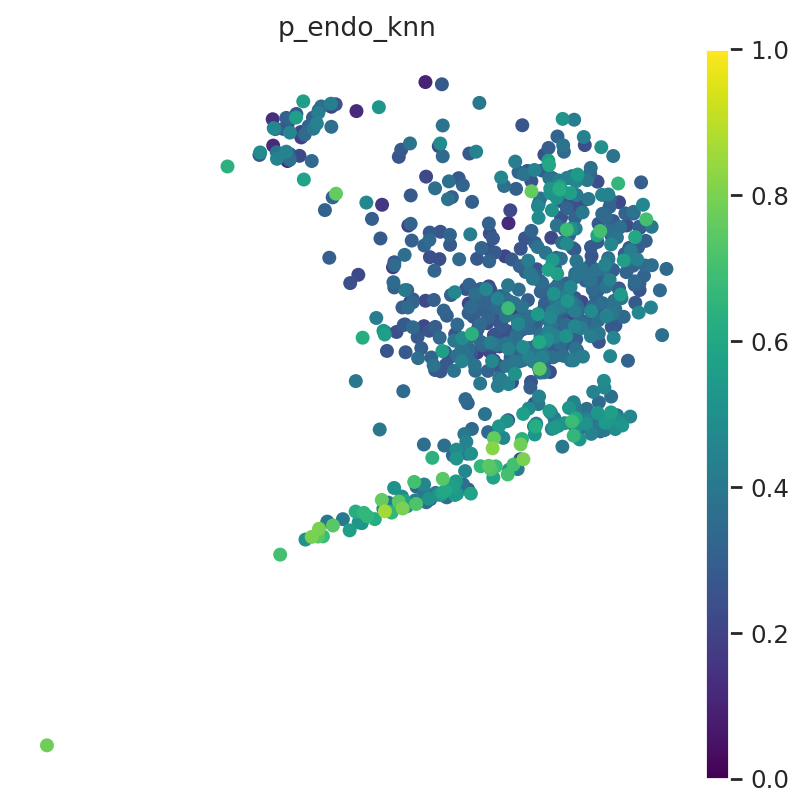

In [30]:
sc.pl.umap(
    adata_query_stromal,
    color="p_endo_knn",
    cmap="viridis",
    vmin=0, vmax=1,
)


In [31]:
df_plot = pd.DataFrame({
    "p_endo_knn": np.concatenate([p_knn, y_ref]),  # query + biopsy
    "group":      ["ME"]*len(p_knn) + list(adata_ref_stromal.obs["condition"]),
})

sns.violinplot(data=df_plot, x="group", y="p_endo_knn")
plt.show()


The three ME samples are not clearly closer to endometriosis biopsies than to control biopsies in predicted stromal cells. Instead, they occupy an intermediate and somewhat noisy region in the latent space. This suggests that additional biological context and possibly more targeted markers are needed to interpret their relationship to biopsy-derived endometriosis signatures.

In the end, menstrual effluent is not stromal biopsy, but a multi-cellular, inflammatory, blood-contaminated mixture derived from shedding tissue.